In [1]:
import numpy as np
import copy as copy
from scipy.linalg import toeplitz, block_diag
import matplotlib.pyplot as plt
import time
from scipy import sparse
from scipy.sparse import block_diag, issparse, csr_matrix, diags
from scipy.stats.mstats import gmean

In [2]:
cd ../..

/Users/junziz/Desktop/[Updated]Notes_for_Classes/SEMINARS/various_research/boyd_research/distributed_aa/a2dr


In [3]:
import a2dr

In [4]:
from a2dr.precondition import mat_equil

In [14]:
np.random.seed(1)

# ## version 1: random
# m = 10000
# N = 1000
# max_size = 20 # maximum size of each block
# n_list = [np.random.randint(max_size+1) for i in range(N)] # list of variable block sizes n_i
# n = np.sum(n_list) # total variable dimension = n_1 + ... + n_N
# A = np.random.randn(m, n)

# ## version 2: consensus
# N = 4
# ni = 20
# m = ni * (N-1)
# n = ni * N
# n_list = [ni, ni, ni, ni]
# A = np.block([[np.eye(ni), -np.eye(ni), np.zeros((ni,ni)), np.zeros((ni,ni))],
#               [np.zeros((ni,ni)), np.eye(ni), -np.eye(ni), np.zeros((ni,ni))],
#               [np.zeros((ni,ni)), np.zeros((ni,ni)), np.eye(ni), -np.eye(ni)]])

# ## version 3: l1_trend_filtering
# def prox_norm1(alpha = 1.0):
#     return lambda v, t: (v - t*alpha).maximum(0) - (-v - t*alpha).maximum(0) if sparse.issparse(v) else \
#                         np.maximum(v - t*alpha,0) - np.maximum(-v - t*alpha,0)

# Problem data.
n0 = 2*10**4
n = 2*n0-2
m = n0-2
y = np.random.randn(n)
alpha = 0.1*np.linalg.norm(y, np.inf)

# Form second difference matrix.
D = sparse.lil_matrix(sparse.eye(n0))
D.setdiag(-2, k = 1)
D.setdiag(1, k = 2)
D = D[:(n0-2),:]

# Convert problem to standard form.
# f_1(x_1) = (1/2)||y - x_1||_2^2, f_2(x_2) = \alpha*||x_2||_1.
# A_1 = D, A_2 = -I_{n-2}, b = 0.
prox_list = [lambda v, t: (t*y + v)/(t + 1.0), prox_norm1(alpha)]
A_list = [D, -sparse.eye(n0-2)]
b = np.zeros(n0-2)

n_list = [A.shape[1] for A in A_list]
A_list_dense = [(A_list[i].todense() if issparse(A_list[i]) else A_list[i]) for i in range(len(A_list))]
A = np.array(np.hstack(A_list_dense))

## common part
tol = 1e-6 # tolerance for terminating the equilibration
max_iter = 10000 # maximum number of iterations for terminating the equilibration

In [15]:
d, e, B, k = mat_equil(A, n_list, tol, max_iter)

Block matrix shape = (19998, 2)
gamma=7.451325729496777e-09
k=0, err_d=0.7142857148939873, err_e=1.7921510389826194
k=1, err_d=3.738336806780049e-09, err_e=3.282826815346747e-08
generate D, E
compute scaled matrix


In [16]:
print('[Sanity Check]')
print('len(d) = {}, len(e) = {}, iter number = {}'.format(len(d), len(e), k))
print('gmean(d) = {}, gmean(e) = {}'.format(gmean(d), gmean(e)))
print('\|A\|_2 = {}, \|DAE\|_2 = {}'.format(np.linalg.norm(A), np.linalg.norm(B)))
print('min(|A|) = {}, max(|A|) = {}, mean(|A|) = {}'.format(np.min(np.abs(A)), 
                                                            np.max(np.abs(A)), np.average(np.abs(A))))
print('min(|B|) = {}, max(|B|) = {}, mean(|B|) = {}'.format(np.min(np.abs(B)), 
                                                            np.max(np.abs(B)), np.average(np.abs(B))))

[Sanity Check]
len(d) = 19998, len(e) = 2, iter number = 1
gmean(d) = 0.06721782453705309, gmean(e) = 0.06721782453705297
\|A\|_2 = 374.1470299227297, \|DAE\|_2 = 1.4142135623730705
min(|A|) = 0.0, max(|A|) = 2.0, mean(|A|) = 0.00012500625031251563
min(|B|) = 0.0, max(|B|) = 0.0070714213533541025, mean(|B|) = 4.654983797554271e-07


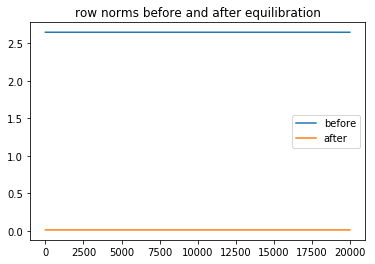

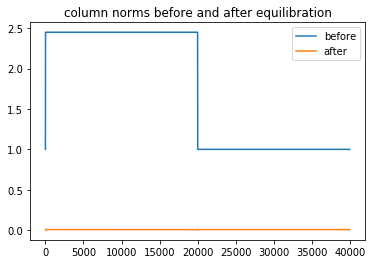

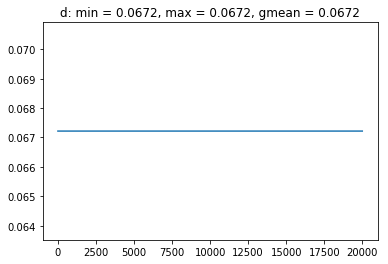

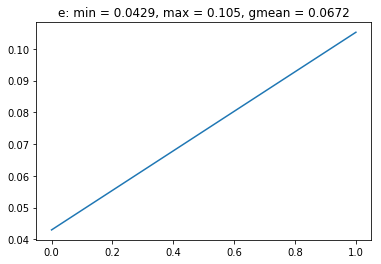

In [17]:
# row norms
A_norms_r = np.sqrt((A**2).dot(np.ones(n))) 
B_norms_r = np.sqrt((np.array(B)**2).dot(np.ones(n))) 
#scale_r = np.mean(A_norms_r) / np.mean(B_norms_r)
#A_norms_r = A_norms_r / scale_r

# column norms
A_norms_c = np.sqrt(np.ones(m).dot(A**2))
B_norms_c = np.sqrt(np.ones(m).dot(np.array(B)**2))
#scale_c = np.mean(A_norms_c) / np.mean(B_norms_c)
#A_norms_c = A_norms_c / scale_c

# visualization of row norms
plt.plot(A_norms_r)
plt.plot(B_norms_r)
plt.title('row norms before and after equilibration')
plt.legend(['before', 'after'])
plt.show()

# visualization of column norms
plt.plot(A_norms_c)
plt.plot(B_norms_c)
plt.title('column norms before and after equilibration')
plt.legend(['before', 'after'])
plt.show()

# visualization of left scaling d
plt.plot(d)
plt.title('d: min = {:.3}, max = {:.3}, gmean = {:.3}'.format(np.min(d), np.max(d), gmean(d)))
plt.show()

# visualization of right scaling e
plt.plot(e)
plt.title('e: min = {:.3}, max = {:.3}, gmean = {:.3}'.format(np.min(e), np.max(e), gmean(e)))
plt.show()

# debug into the equilibration step

In [5]:
# debug into the equilibration step
def prox_sum_squares(X, y, type = "lsqr"):
    n = X.shape[1]
    if type == "lsqr":
        X = sparse.csr_matrix(X)
        def prox(v, t):
            A = sparse.vstack([X, 1/np.sqrt(2*t)*sparse.eye(n)])
            b = np.concatenate([y, 1/np.sqrt(2*t)*v])
            return sparse.linalg.lsqr(A, b, atol=1e-16, btol=1e-16)[0]
    elif type == "lstsq":
        def prox(v, t):
            A = np.vstack([X, 1/np.sqrt(2*t)*np.eye(n)])
            b = np.concatenate([y, 1/np.sqrt(2*t)*v])
            return LA.lstsq(A, b, rcond=None)[0]
    else:
        raise ValueError("Algorithm type not supported:", type)
    return prox

m, n = 100, 1000
density = 0.001
beta_true = np.array(np.arange(-n/2,n/2) + 1)
#X = np.random.randn(n,n)
X = sparse.random(m, n, density=density, data_rvs=np.random.randn)
#y = X.dot(beta_true) + np.random.randn(n)
y = np.random.randn(m)


prox_list = [prox_sum_squares(X, y), lambda v, t: v.maximum(0) if sparse.issparse(v) else np.maximum(v,0)]
A_list = [sparse.eye(n), -sparse.eye(n)]
b = np.zeros(n)

In [6]:
from scipy.sparse import issparse
from scipy.sparse import csr_matrix

In [7]:
n_list = [A.shape[1] for A in A_list]
A_list_dense = [(A_list[i].todense() if issparse(A_list[i]) else A_list[i]) for i in range(len(A_list))]
A = np.array(np.hstack(A_list_dense))
d, e, A_hat, k = mat_equil(A, n_list, 1e-6, 1000)

array([0.17782794, 0.17782794])

In [7]:
from a2dr.precondition import precondition

In [8]:
p_list, A_list_1, b_1, e_pre = precondition(prox_list, A_list, b, tol = 1e-6, max_iter = 1000)

In [99]:
v = np.random.randn(X.shape[1])
rho = 10
np.linalg.norm(p_list[0](v,rho) - prox_list[0](v,rho)) # not equal, but should equal

24.047734095084536

# write out the core step in precondition above

In [100]:
# write out the core step in precondition above
p_eq_list = [lambda v, rho: prox(ei*v, rho/ei**2)/ei for prox, ei in zip(prox_list, e_pre)]

In [103]:
v = np.random.randn(X.shape[1])
rho = 10
print(np.linalg.norm(p_eq_list[0](v,rho) - p_eq_list[1](v,rho)))
print(np.linalg.norm(p_eq_list[0](v,rho) - prox_list[0](v,rho))) # same failure as above

0.0
23.865866227844432


# Find out the reason: prox and ei are modified in place inside the new lambda functions

In [125]:
p_eq_list = []
for i in range(len(prox_list)):
    prox = prox_list[i]
    ei = e_pre[i]
    tmp = lambda v, rho: prox(ei*v, rho/ei**2)/ei
    p_eq_list.append(tmp)

In [126]:
v = np.random.randn(X.shape[1])
rho = 10
print(np.linalg.norm(p_eq_list[0](v,rho) - p_eq_list[1](v,rho)))
print(np.linalg.norm(p_eq_list[0](v,rho) - prox_list[0](v,rho)))

0.0
25.081935431942505


In [127]:
prox = prox_list[0]
tmp = lambda v, rho: prox(ei*v,rho/ei**2)/ei
print(np.linalg.norm(tmp(v,rho) - prox_list[0](v,rho)))
print(np.linalg.norm(p_eq_list[0](v,rho) - prox_list[0](v,rho)))

0.0
0.0


In [132]:
# v = np.random.randn(X.shape[1])
# rho = 10
# print(np.linalg.norm(p_eq_list[0](v,rho) - p_eq_list[1](v,rho)))
# print(np.linalg.norm(p_eq_list[0](v,rho) - prox_list[0](v,rho)))

In [131]:
## How to resolve it? This is also wrong, since i is modified in place
p_eq_list = []
for i in range(len(prox_list)):
    p_eq_list.append(lambda v, rho: prox_list[i](e_pre[i]*v, rho/e_pre[i]**2)/e_pre[i])
    
v = np.random.randn(X.shape[1])
rho = 10
print(np.linalg.norm(p_eq_list[0](v,rho) - p_eq_list[1](v,rho)))
print(np.linalg.norm(p_eq_list[0](v,rho) - prox_list[0](v,rho)))

0.0
25.02088196593658


In [139]:
tmp0 = lambda v, rho: prox_list[0](e_pre[0]*v, rho/e_pre[0]**2)/e_pre[0]
tmp1 = lambda v, rho: prox_list[1](e_pre[1]*v, rho/e_pre[1]**2)/e_pre[1]
print(np.linalg.norm(tmp0(v,rho) - prox_list[0](v,rho)))
print(np.linalg.norm(tmp1(v,rho) - prox_list[1](v,rho)))

0.0
0.0


In [136]:
tmp_all = [tmp0, tmp1]
np.linalg.norm(tmp_all[0](v,rho) - tmp_all[1](v,rho))

25.02088196593658

In [147]:
# similar: https://stackoverflow.com/questions/6076270/lambda-function-in-list-comprehensions
xyz = [lambda x: x*x for x in range(10)]
print(xyz[1](4))
print(xyz[2](4))

16
16


In [176]:
# Correct solution
def proto(i, prox_list, e_pre):
    return lambda v, rho: prox_list[i](e_pre[i]*v, rho/e_pre[i]**2)/e_pre[i]
p_eq_list = list(map(lambda i: proto(i,prox_list,e_pre), range(len(prox_list))))
v = np.random.randn(X.shape[1])
rho = 10
print(np.linalg.norm(p_eq_list[0](v,rho) - p_eq_list[1](v,rho)))
print(np.linalg.norm(p_eq_list[0](v,rho) - prox_list[0](v,rho)))

24.653665155186953
0.0


In [175]:
proto

<function __main__.<lambda>(v, rho, i)>

In [9]:
# precondition(prox_list, A_list, b, tol = 1e-6, max_iter = 1000)

In [10]:
# b == b